# Identifying local connectivity structure

In [1]:
# Set working directory --- edit to navigate to where you downloaded the repository
import os
homedir = os.path.expanduser("~")
projdir = os.path.join(homedir,"Documents","Research","GitHub","local-connectivity-structure")  

In [2]:
# Limit computational resource use (CPU) granted to numpy for parallelizing computations 
# Keeps you from overwhelming a shared server in running the matrix calculations
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"

In [3]:
# Data handling
import pandas as pd
import numpy as np
import copy
import csv

# Analysis
import networkx as nx    
import scipy as sp
import random
import math

# Visualization
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import seaborn as sns
%matplotlib inline

In [4]:
# Version check
print("pd", pd.__version__)
print("nx", nx.__version__)     # need version 2
print("np", np.__version__)
print("sp", sp.__version__)     # scipy >1.5 to avoid this issue with matrix exponentials: https://github.com/scipy/scipy/issues/11839

pd 1.0.5
nx 2.4
np 1.18.5
sp 1.5.0


### Social & functional networks

#### Copenhagen Networks Study, Facebook friendships
From: https://www.nature.com/articles/s41597-019-0325-x   
Downloaded: https://figshare.com/articles/dataset/The_Copenhagen_Networks_Study_interaction_data/7267433/1

In [5]:
friendships_file = os.path.join(projdir,"datasets","copenhagen","fb_friends.csv")
friendships = pd.read_csv(friendships_file, names = ["user_a","user_b"], header = 0, dtype = str)
friendships.head()

,user_a,user_b
0,0,512
1,0,263
2,0,525
3,0,285
4,0,543


#### Human interactome, Version III (2017)
From: https://www.nature.com/articles/s41467-019-09177-y      
Downloaded: https://github.com/kpisti/L3/tree/v1.0.2

In [6]:
interactions_file = os.path.join(projdir,"datasets","kpisti-L3-ed6b18f","hi-iii.txt")
interactions = pd.read_csv(interactions_file, sep = '\t', names = ["protein_a","protein_b","weight"], dtype = str)
interactions = interactions.drop("weight",axis=1)
interactions.head()

,protein_a,protein_b
0,14,64782
1,27,9322
2,27,10152
3,30,7919
4,33,7051


## Measures & methods

Spectral bipartivity can be re-purposed to identify local connectivity structure in networks using a comparison to random expectation. This measure quantifies the over-representation of even vs. odd cycles in the local connectivity structure of a network. Random networks give us the baseline. Social networks have lots of triangles and so are _less_ bipartite than random expectation. Functional networks have lots of squares and so are _more_ bipartite than random expectation. Two-mode networks are bipartite and would have a value of 1. Below is a toy example of how social, random, functional, and two-mode networks with the same number of nodes and edges are arranged according to their value of spectral bipartivity. 

![A toy example of how social, random, functional, and two-mode networks with seven nodes and eleven edges show increasing spectral bipartivity.](scale.jpg?raw=true)

#### Estrada index
The [Estrada index](https://www.sciencedirect.com/science/article/abs/pii/S0009261400001585) is an absolute measure of local connectivity. This measure quantifies the local density of cycles by having closed paths contribute progressively less to the value of the measure as they take more steps to complete. The value of the Estrada index for a network, $G$ with $n$ nodes can be computed as the trace of the matrix exponential of that network's adjacency matrix, $A$. The equation below gives this definition as well as an alternative formulation where $\lambda_{1} \leq \cdots \leq \lambda_{n}$ are the eigenvalues of $A$. 

$$
EE(G) 
= tr \exp(A)
= \sum_{j=1}^{n} e^{\lambda_j} 
$$

#### Spectral bipartivity

[Spectral bipartivity](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.72.046105) ($b_s$) is a variation of the Estrada index that separates the contribution of even and odd closed paths. This is done using the hyperbolic sine and cosine matrix functions, which add up to the matrix exponential, as applied to a network's adjacency matrix. With [proper normalization](https://www.sciencedirect.com/science/article/abs/pii/S016727891500216X), spectral bipartivity ranges from $0$ when the network is fully complete to $1$ when the network is fully bipartite. Two-mode networks are the extreme case where the bipartite constraint on link formation entirely disallows odd cycles. The equation below defines several equivalent formulations of spectral bipartivity. 

$$
b_s(G)
= \frac{tr \cosh(A) - tr \sinh(A)}{tr \cosh(A) + tr \sinh(A)} 
= \frac{tr \exp(-A)}{tr \exp(A)}
= \frac{\sum_{j=1}^{n} e^{-\lambda_j}}{\sum_{j=1}^{n} e^{\lambda_j}}
$$


In [7]:
def bipartivity(nx_graph,weight=None,nodes={},label="idx"):
    tmp = copy.deepcopy(nx_graph)
    # Standardize the indices
    tmp_idx = nx.convert_node_labels_to_integers(tmp,label_attribute="idx")
    name_idx = {value:key for key, value in nx.get_node_attributes(tmp_idx,label).items()}
    # Generate node sets
    node_sets = {"all":list(tmp_idx.nodes)}
    for node_set in nodes:
        idxs = [name_idx[name] for name in nodes[node_set] if name in name_idx]
        if idxs:
            node_sets[node_set] = idxs
        else:
            print(",".join(["Warning: nodes list empty for nodes set: ",node_set]))
    # Convert into an adjacency matrix
    np_graph = nx.to_numpy_array(tmp_idx,weight=weight)
    # Check for overflow
    n_row, n_col = np_graph.shape
    eig_A = sp.linalg.eigh(np_graph,eigvals_only=True,subset_by_index=[n_row-1,n_row-1])
    eig_nA = sp.linalg.eigh(-1*np_graph,eigvals_only=True,subset_by_index=[n_row-1,n_row-1])
    bp_num_approx = np.exp(eig_nA)
    bp_den_approx = np.exp(eig_A)
    # If the result will be finite, continue
    if np.isfinite(bp_num_approx) & np.isfinite(bp_den_approx):
        # Compute the matrix exponentials
        bp_num = np.diagonal(sp.linalg.expm(-1*np_graph))
        bp_den = np.diagonal(sp.linalg.expm(np_graph))
        # Calculate the bipartivity
        bp = {}
        for node_set in node_sets:
            bp[node_set] = {}
            idxs = node_sets[node_set]
            bp[node_set]["bp"] = np.sum(bp_num[idxs])/np.sum(bp_den[idxs])
            bp[node_set]["bps"] = np.divide(bp_num[idxs],bp_den[idxs])
            bp[node_set]["bp_avg"] = np.mean(bp[node_set]["bps"])
            bp[node_set]["ids"] = [tmp_idx.nodes[idx][label] for idx in idxs]
            bp[node_set]["n"] = len(bp[node_set]["ids"])
        return bp
    # Otherwise report the approximations
    else:
        print("Non-finite exponential, as approximated by the largest eigenvalues [exp(lev_-A)/exp(lev_A)].")
        print("Largest eigenvalue -A:",eig_nA)
        print("Largest eigenvalue  A:",eig_A)
        return None

In [8]:
def convert_to_table_bp(bp_dict,network_name,instance,version,focal_subset):
    row = {}
    row['network'] = network_name
    row['instance'] = instance
    row['version'] = version
    row['subset']  = focal_subset
    row['n']       = bp_dict[focal_subset]['n']
    row['bp']      = bp_dict[focal_subset]['bp']
    row['bp_avg']  = bp_dict[focal_subset]['bp_avg']
    return row

In [9]:
def report_bipartivity(bipartivity_dict,bipartivity_filename,network_name="network",version="empirical",instance=None):
    
    bipartivity_header = ["network","version","instance","subset","n","bp","bp_avg"]
    
    # Write to file -- whole-network
    with open(bipartivity_filename,'a') as output_file:
        output_writer = csv.DictWriter(output_file,fieldnames=bipartivity_header)
        for focal_subset in bipartivity_dict:
            row = convert_to_table_bp(bipartivity_dict,network_name,instance,version,focal_subset)
            output_writer.writerow(row)

In [10]:
def initialize_node_bipartivity(_network_):

    name_idx = {}
    nodes_dict = {}
    
    # Node labels
    for node, be_id in _network_.nodes(data="BE_ID"):
        nodes_dict[be_id] = {}
        nodes_dict[be_id]["BE_ID"] = be_id
        nodes_dict[be_id]["idx"] = node
        name_idx[node] = be_id
        
    # Node degree
    for node, deg in _network_.degree():
        nodes_dict[name_idx[node]]["k"] = deg
        
    return nodes_dict

In [11]:
def report_bipartivities(bipartivity_dict,bipartivities_filename,nodes_dict,network_name="network",version="empirical",instance=None):
    
    bipartivities_header = ["network","instance","version","idx","BE_ID","k","bp"]

    if bipartivities_filename and nodes_dict:
        # Write to file -- nodel-level
        with open(bipartivities_filename,'a') as output_file:
            output_writer = csv.DictWriter(output_file,fieldnames=bipartivities_header)
            # Node bipartivity
            for be_id, bp in zip(bipartivity_dict["all"]["ids"],bipartivity_dict["all"]["bps"]):
                nodes_dict[be_id]["bp"] = bp 
            for key, row in nodes_dict.items():
                row.update({"network":network_name,"instance":instance,"version":version})
                output_writer.writerow(row)

#### Spectral bipartivity, logit approximation

We primarily consider the value of the spectral bipartivity under a logistic transformation, because this metric is restricted in range from $0$ to $1$ and the Estrada index in the denominator [can become quite large](https://www.sciencedirect.com/science/article/pii/S0024379507002844). It's also nice in that logit spectral bipartivity can also be approximated for networks that fulfill the following two conditions. First, when the spectral bipartivity is very small, i.e. $b_s \approx 0$, the logistic transformation is closely approximated by a log transformation. Second, whenever the most positive and most negative eigenvalues of a network's adjacency matrix are substantially larger in magnitude than their neighboring eigenvalue, i.e. $\lambda_1 \ll \lambda_2$ and $\lambda_{n} \gg \lambda_{n-1}$, these eigenvalues will dominate the exponential sums in the numerator and denominator of spectral bipartivity. The equation below describes these approximations.

$$
\begin{array}{c}
\textrm{logit}(b_s) 
 =  \log{\frac{b_s}{1-b_s}}
= \log{b_s} - \log{(1-b_s)}
\approx \log{b_s}\\
\log(b_s)  =  \log{\frac{\sum_{j=1}^{n} e^{-\lambda_j}}{\sum_{j=1}^{n} e^{\lambda_j}}} 
\approx \log{\frac{e^{-\lambda_1}}{e^{\lambda_n}}}
= - (\lambda_1 + \lambda_n)
\end{array}
$$

In [12]:
def bipartivity_approx(nx_network,evs=1,weight=None):
    # Convert into an adjacency matrix
    sp_network = nx.to_scipy_sparse_matrix(nx_network,weight=weight)
    # Initialize the output dictionary
    bp_approx = {}
    # Compute the top eigenvalues
    bp_approx["evs_A"] = list(sp.sparse.linalg.eigsh(sp_network.asfptype(),k=2*evs,return_eigenvectors=False,which='BE'))
    # Get the approximation of the logit bipartivity from the top eigenvalues
    bp_approx["logit_bp"] = -1*min(bp_approx["evs_A"]) - max(bp_approx["evs_A"])
    # Report the approximations
    return bp_approx

In [13]:
def convert_to_table_bp_approx(bp_dict,network_name,version,instance):
    row = {}
    row['network'] = network_name
    row['version'] = version
    row['instance'] = instance
    row['logit_bp'] = bp_dict["logit_bp"]
    evs = int(len(bp_dict["evs_A"])/2)
    idx = [-(i+1) for i in range(evs)]+[i+1 for i in reversed(range(evs))]
    for i, ev in zip(idx,bp_dict["evs_A"]):
        row["ev_A_"+str(i)] = ev
    return row

In [14]:
def report_bipartivity_approx(bipartivity_dict,bipartivity_filename,evs=1,network_name="network",version="empirical",instance=None):
    
    bipartivity_header = ["network","version","instance","logit_bp"]+["ev_A_"+str(-(i+1)) for i in range(evs)]+["ev_A_"+str(i+1) for i in reversed(range(evs))]
    
    # Write to file -- whole-network approximation
    with open(bipartivity_filename,'a') as output_file:
        output_writer = csv.DictWriter(output_file,fieldnames=bipartivity_header)
        row = convert_to_table_bp_approx(bipartivity_dict,network_name,version,instance)
        output_writer.writerow(row)

#### Degree-preserving randomization
The random expectation is found by calculating spectral bipartivity on a set of random networks comparable to our networks of trading relationships. [Degree](https://www.jstor.org/stable/25051102)-[preserving](https://dl.acm.org/doi/10.1145/1297332.1297338) [randomization](https://arxiv.org/abs/cond-mat/0312028) produces random networks that maintain the number of companies, the number of unique inter-company links, and the degree of each company. We use a version of this called random pairwise rewiring, wherein pairs of edges are selected and an end point of each edge are swapped. Our implementation also guarantees that the randomized network remains simple by following through with a rewire only so long as it will not introduce self-loops or multi-edges. Randomization continues until $10 \cdot m$ pairs of links have been rewired, where $m$ is the number of simple edges. 

In [15]:
def pairwise(iterable):
    tmp = iter(iterable)
    return zip(tmp,tmp)

In [16]:
# Random edge rewiring with simplicity constraint
def rewire(_network_,rewire=10,limit=100,directed=False):
    config = _network_.copy()
    # Numer of edges to rewire
    total_rewired = rewire*config.number_of_edges()
    rewired = 0
    loops = 0
    # Randomly rewire pairs of edges, without creating multi-edges or self-loops
    while rewired < total_rewired:
        # If this has gone on too long, abort mission
        if loops > limit:
            print("Exited loop after 100 itterations over edges. Pairs rewired:",rewired)
            break
        # Get a list of the edges
        to_rewire = list(config.edges())
        # Shuffle this list and loop through it pairwise
        random.shuffle(to_rewire)
        for edge1, edge2 in pairwise(to_rewire):
            rewire = False
            # Randomly choose one of the rewiring directions, unless directed in which case use the available direction
            if directed or random.random() < 0.5:
                # Rewire unless it will create a multi-edge or self-loop
                if (config.has_edge(edge1[0],edge2[1]) | config.has_edge(edge2[0],edge1[1])) | ((edge1[0]==edge2[1]) | (edge2[0]==edge1[1])):
                    continue
                else:
                    config.add_edge(edge1[0],edge2[1])
                    config.add_edge(edge2[0],edge1[1])
                    rewire = True
            else:
                # Rewire unless it will create a multi-edge or self-loop
                if (config.has_edge(edge1[0],edge2[0]) | config.has_edge(edge1[1],edge2[1])) | ((edge1[0]==edge2[0]) | (edge1[1]==edge2[1])):
                    continue
                else:
                    config.add_edge(edge1[0],edge2[0])
                    config.add_edge(edge1[1],edge2[1])
                    rewire = True
            # Remove the old edges and update the count (if the rewiring went through)
            if rewire:
                config.remove_edge(edge1[0],edge1[1])
                config.remove_edge(edge2[0],edge2[1])
                # Update the total
                rewired += 1
        loops += 1
    # Return
    return config

#### Statistics

We use the [Kolmogorov–Smirnov test](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-32833-1_214). The $KS$ statistic quantifies the (lack of) overlap between distributions; $KS = 0$ indicates identical distributions and $KS = 1$ indicates non-overlapping distributions, i.e. one is consistently less/greater than the other. The statistical power of the test is a function of the size of the two distributions and the overlap between then. In analyzing the local connectivity structure of a network, we compare their values of spectral bipartivity against those of their many randomized versions. Note that comparisons between two distributions have much higher statistical power under non-parametric tests, like this one, than those between a distribution and a single value. For that, the best you can get, with $KS = 1$, is $p = 1/(n+1)$. 

In [17]:
sp.stats.ks_2samp(random.sample(range(1,60), 10),random.sample(range(51,100), 10),alternative="greater")

KstestResult(statistic=0.8, pvalue=0.0010283833813245578)

In [18]:
sp.stats.ks_2samp(random.sample(range(1,60), 10),random.sample(range(51,100), 10),alternative="less")

KstestResult(statistic=0.0, pvalue=1.0)

## Computations

In [19]:
# Output filename 
bipartivity_filename = os.path.join(projdir,"bipartivity.csv")
bipartivity_approx_filename = os.path.join(projdir,"bipartivity_approx.csv")
bipartivity_approx_evs = 3 # number of eigenvalues used in approximation
# Initialize files
bipartivity_header = ["network","version","instance","subset","n","bp","bp_avg"]
with open(bipartivity_filename,'w') as output_file:
    output_writer = csv.DictWriter(output_file,fieldnames=bipartivity_header)
    output_writer.writeheader()  
# Initialize file
bipartivity_approx_header = ["network","version","instance","logit_bp"]+["ev_A_"+str(-(i+1)) for i in range(bipartivity_approx_evs)]+["ev_A_"+str(i+1) for i in reversed(range(bipartivity_approx_evs))]
with open(bipartivity_approx_filename,'w') as output_file:
    output_writer = csv.DictWriter(output_file,fieldnames=bipartivity_approx_header)
    output_writer.writeheader()    

In [20]:
# Load into NetworkX
G_friendships = nx.from_pandas_edgelist(friendships,source="user_a",target="user_b",create_using=nx.Graph)
G_interactions = nx.from_pandas_edgelist(interactions,source="protein_a",target="protein_b",create_using=nx.Graph)

In [21]:
# Compute bipartivity
bp_friendships = bipartivity(G_friendships)
bp_interactions = bipartivity(G_interactions)

In [22]:
# Report bipartivity
report_bipartivity(bp_friendships,bipartivity_filename,network_name="friendships",version="empirical")
report_bipartivity(bp_interactions,bipartivity_filename,network_name="interactions",version="empirical")

In [23]:
# Compute & report approx logit spectral bipartivity
bp_approx_interactions = bipartivity_approx(G_interactions, evs=bipartivity_approx_evs)
report_bipartivity_approx(bp_approx_interactions,bipartivity_approx_filename,evs=bipartivity_approx_evs,network_name="interactions",version="empirical")

In [24]:
# Now generate the randomized versions against which we will compare, and compute their bipartivity
randomizations = 25  

In [25]:
#### Randomize ####
for i in range(randomizations):
    # Generate rewired network
    G_friendships_rw = rewire(G_friendships)
    # Compute bipartivity
    bp_friendships_rw = bipartivity(G_friendships_rw)
    # Report bipartivity
    report_bipartivity(bp_friendships_rw,bipartivity_filename,network_name="friendships",version="rewired",instance=i)
    # Update progress
    print("Reported comparison:",i)

Reported comparison: 0
Reported comparison: 1
Reported comparison: 2
Reported comparison: 3
Reported comparison: 4
Reported comparison: 5
Reported comparison: 6
Reported comparison: 7
Reported comparison: 8
Reported comparison: 9
Reported comparison: 10
Reported comparison: 11
Reported comparison: 12
Reported comparison: 13
Reported comparison: 14
Reported comparison: 15
Reported comparison: 16
Reported comparison: 17
Reported comparison: 18
Reported comparison: 19
Reported comparison: 20
Reported comparison: 21
Reported comparison: 22
Reported comparison: 23
Reported comparison: 24


In [26]:
#### Randomize ####
for i in range(randomizations):
    # Generate rewired network
    G_interactions_rw = rewire(G_interactions)
    # Compute bipartivity
    bp_interactions_rw = bipartivity(G_interactions_rw)
    # Report bipartivity
    report_bipartivity(bp_interactions_rw,bipartivity_filename,network_name="interactions",version="rewired",instance=i)
    # Compute & report approx logit bipartivity
    bp_approx_interactions_rw = bipartivity_approx(G_interactions_rw, evs=bipartivity_approx_evs)
    report_bipartivity_approx(bp_approx_interactions_rw,bipartivity_approx_filename,evs=bipartivity_approx_evs,network_name="interactions",version="rewired",instance=i)
    # Update progress
    print("Reported comparison:",i)

Reported comparison: 0
Reported comparison: 1
Reported comparison: 2
Reported comparison: 3
Reported comparison: 4
Reported comparison: 5
Reported comparison: 6
Reported comparison: 7
Reported comparison: 8
Reported comparison: 9
Reported comparison: 10
Reported comparison: 11
Reported comparison: 12
Reported comparison: 13
Reported comparison: 14
Reported comparison: 15
Reported comparison: 16
Reported comparison: 17
Reported comparison: 18
Reported comparison: 19
Reported comparison: 20
Reported comparison: 21
Reported comparison: 22
Reported comparison: 23
Reported comparison: 24


## Analysis

In [50]:
# Output filename 
bipartivity_filename = os.path.join(projdir,"bipartivity.csv")
# Load bipartivities from file
bipartivity = pd.read_csv(bipartivity_filename)
bipartivity.head()

,network,version,instance,subset,n,bp,bp_avg
0,friendships,empirical,NaN,all,800,1.218572e-09,0.000002
1,interactions,empirical,NaN,all,5604,3.104255e-06,0.033003
2,friendships,rewired,0.0,all,800,6.737164e-07,0.000001
3,friendships,rewired,1.0,all,800,5.711086e-07,0.000001
4,friendships,rewired,2.0,all,800,6.057843e-07,0.000001


In [51]:
# This measure is trapped 0 to 1 --- use logit transformation
bipartivity["logit_bp"] = bipartivity["bp"].apply(lambda x: np.log(x/(1-x)))

### Social network

In [52]:
# Consider the network of person-person friendships
bipartivity_friendships = bipartivity[bipartivity["network"]=="friendships"]

In [53]:
# Extract distributions
dist_randomized = bipartivity_friendships[bipartivity_friendships["version"]=="rewired"]["logit_bp"].squeeze().tolist()
dist_original = bipartivity_friendships[bipartivity_friendships["version"]=="empirical"]["logit_bp"].squeeze()

#### Compare statistically
For a social network, the hypothesis is that the (logit) spectral bipartivity will be consistently and significantly _smaller_ than random expectation.

In [54]:
# Use the KS test
sp.stats.ks_2samp(dist_randomized,[dist_original],alternative="less")

KstestResult(statistic=1.0, pvalue=0.038461538461538464)

#### Plot

In [55]:
# Assemble into a dataframe for plotting
bipartivity_plot = pd.DataFrame({"Randomized":dist_randomized,"Empirical":dist_original}).melt()

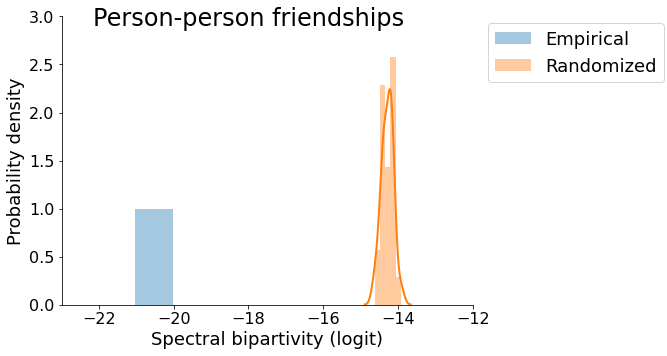

In [57]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7, 5))
  
# Draw the density plot
sns.distplot(bipartivity_plot[bipartivity_plot['variable'] == "Randomized"]['value'], hist = True, kde = True, norm_hist=True, color=sns.color_palette()[1],
             kde_kws = {'linewidth': 2},
             ax=ax, label = "Randomized")

# Draw a line for the actual value
sns.distplot(bipartivity_plot[bipartivity_plot['variable'] == "Empirical"]['value'], hist = True, kde = False, norm_hist=True, bins = 1,
             ax=ax, label = "Empirical")

    
# Plot formatting
ax.set_xlim([-23,-12])
ax.set_ylim([0,3])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Probability density',size=18)
ax.set_xlabel('Spectral bipartivity (logit)',size=18)
ax.tick_params(labelsize=16)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(reversed(handles),reversed(labels),prop={'size': 18}, bbox_to_anchor=(0.95,0.95), loc='upper left')

fig.tight_layout()
fig.suptitle("Person-person friendships",size=24)
fig.savefig(os.path.join(projdir,"bp_friendships.pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join(projdir,"bp_friendships.jpg"), bbox_extra_artists=(lgd,), bbox_inches='tight')

### Functional network

In [58]:
# Consider the network of protein-protein interactions
bipartivity_interactions = bipartivity[bipartivity["network"]=="interactions"]

In [59]:
# Extract distributions
dist_randomized = bipartivity_interactions[bipartivity_interactions["version"]=="rewired"]["logit_bp"].squeeze().tolist()
dist_original = bipartivity_interactions[bipartivity_interactions["version"]=="empirical"]["logit_bp"].squeeze()

#### Compare statistically
For a functional network, the hypothesis is that the (logit) spectral bipartivity will be consistently and significantly _greater_ than random expectation.

In [60]:
# Use the KS test
sp.stats.ks_2samp(dist_randomized,[dist_original],alternative="greater")

KstestResult(statistic=1.0, pvalue=0.038461538461538464)

#### Plot

In [61]:
# Assemble into a dataframe for plotting
bipartivity_plot = pd.DataFrame({"Randomized":dist_randomized,"Empirical":dist_original}).melt()

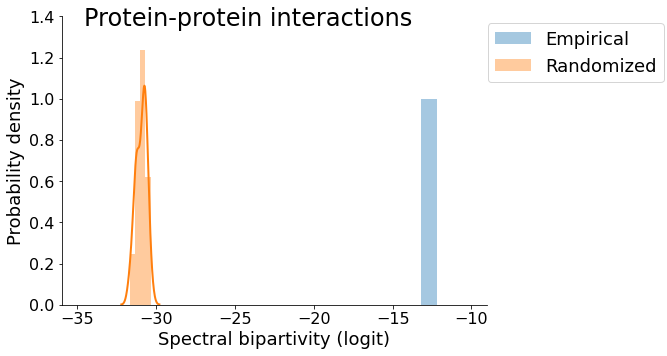

In [62]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7, 5))
  
# Draw the density plot
sns.distplot(bipartivity_plot[bipartivity_plot['variable'] == "Randomized"]['value'], hist = True, kde = True, norm_hist=True, color=sns.color_palette()[1],
             kde_kws = {'linewidth': 2},
             ax=ax, label = "Randomized")

# Draw a line for the actual value
sns.distplot(bipartivity_plot[bipartivity_plot['variable'] == "Empirical"]['value'], hist = True, kde = False, norm_hist=True, bins = 1,
             ax=ax, label = "Empirical")

    
# Plot formatting
ax.set_xlim([-36,-9])
ax.set_ylim([0,1.4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Probability density',size=18)
ax.set_xlabel('Spectral bipartivity (logit)',size=18)
ax.tick_params(labelsize=16)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(reversed(handles),reversed(labels),prop={'size': 18}, bbox_to_anchor=(0.95,0.95), loc='upper left')

fig.tight_layout()
fig.suptitle("Protein-protein interactions",size=24)
fig.savefig(os.path.join(projdir,"bp_interactions.pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join(projdir,"bp_interactions.jpg"), bbox_extra_artists=(lgd,), bbox_inches='tight')

#### Now using approximation

In [63]:
# Output filename 
bipartivity_approx_filename = os.path.join(projdir,"bipartivity_approx.csv")
# Load bipartivities from file
bipartivity_approx = pd.read_csv(bipartivity_approx_filename)

In [64]:
# Confirm that bipartivity is small and that the extreme eigenvalues are dominant (under exponentiation)
bipartivity_approx.head()

,network,version,instance,logit_bp,ev_A_-1,ev_A_-2,ev_A_-3,ev_A_3,ev_A_2,ev_A_1
0,interactions,empirical,NaN,-12.682739,-39.246266,-26.634541,-22.839218,23.029774,38.269140,51.929005
1,interactions,rewired,0.0,-30.618260,-23.312068,-20.298525,-18.067933,18.587974,20.287658,53.930327
2,interactions,rewired,1.0,-31.501182,-22.519895,-20.948740,-17.654148,18.859586,20.062705,54.021077
3,interactions,rewired,2.0,-31.144481,-22.488403,-20.540740,-17.722044,19.084248,19.489895,53.632884
4,interactions,rewired,3.0,-31.064862,-22.634929,-20.990566,-17.596732,19.047998,19.803477,53.699790


In [65]:
# Extract distributions
dist_randomized = bipartivity_interactions[bipartivity_interactions["version"]=="rewired"]["logit_bp"].squeeze().tolist()
dist_original = bipartivity_interactions[bipartivity_interactions["version"]=="empirical"]["logit_bp"].squeeze()

In [66]:
# Compare statistically
sp.stats.ks_2samp(dist_randomized,[dist_original],alternative="greater")

KstestResult(statistic=1.0, pvalue=0.038461538461538464)

In [67]:
# Assemble into a dataframe for plotting
bipartivity_plot = pd.DataFrame({"Randomized":dist_randomized,"Empirical":dist_original}).melt()

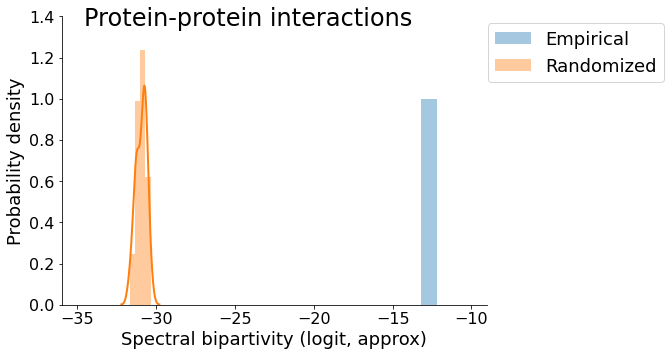

In [68]:
# Same plot
fig, ax = plt.subplots(1,1,figsize=(7, 5))
  
# Draw the density plot
sns.distplot(bipartivity_plot[bipartivity_plot['variable'] == "Randomized"]['value'], hist = True, kde = True, norm_hist=True, color=sns.color_palette()[1],
             kde_kws = {'linewidth': 2},
             ax=ax, label = "Randomized")

# Draw a line for the actual value
sns.distplot(bipartivity_plot[bipartivity_plot['variable'] == "Empirical"]['value'], hist = True, kde = False, norm_hist=True, bins = 1,
             ax=ax, label = "Empirical")

    
# Plot formatting
ax.set_xlim([-36,-9])
ax.set_ylim([0,1.4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Probability density',size=18)
ax.set_xlabel('Spectral bipartivity (logit, approx)',size=18)
ax.tick_params(labelsize=16)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(reversed(handles),reversed(labels),prop={'size': 18}, bbox_to_anchor=(0.95,0.95), loc='upper left')

fig.tight_layout()
fig.suptitle("Protein-protein interactions",size=24)
fig.savefig(os.path.join(projdir,"bp_approx_interactions.pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join(projdir,"bp_approx_interactions.jpg"), bbox_extra_artists=(lgd,), bbox_inches='tight')